In [1]:
import os
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.models as models

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")

Device Used: cuda


In [3]:
def build_people_dict(csv_path, root_dir):
    """
    This function takes the CSV file and creates a dictionary of file paths corresponding to each person in the CSV file.
    """
    df = pd.read_csv(csv_path)
    people_dict = defaultdict(list)
    
    for idx, row in df.iterrows():
        person_name = row['name']
        num_images_expected = row['images']
        
        # Get full folder path
        person_folder = os.path.join(root_dir, person_name)
        
        file_extensions = ('.jpg', '.jpeg', '.png')
        if os.path.exists(person_folder):
            image_files = []
            for file in os.listdir(person_folder):
                if file.endswith(file_extensions):
                    image_files.append(file)
                image_files = sorted(image_files)
    
                # Build the full paths for the images
                full_paths = [os.path.join(person_folder, img_file) for img_file in image_files]
                
                people_dict[person_name].extend(full_paths)
        else:
            print(f"No folder found for person: {person_name}")
    
    return dict(people_dict)

In [4]:
train_csv = "/home/user/javeda1/lwf_dataset/peopleDevTrain.csv"
test_csv = "/home/user/javeda1/lwf_dataset/peopleDevTest.csv"
root_dir = "/home/user/javeda1/lwf_datasets"  # Folder containing image subfolders

people_dict_train = build_people_dict(train_csv, root_dir)
people_dict_test = build_people_dict(test_csv, root_dir)

In [5]:
class LFWDataset(Dataset):
    def __init__(self, people_dict, transform=None, num_samples=10000):
        self.people_dict = people_dict
        self.person_ids = list(people_dict.keys())
        self.transform = transform
        self.num_samples = num_samples
        
        self.label2id = {person: idx for idx, person in enumerate(self.person_ids)}

    def __len__(self):
        return len(self.people_dict)

    def __getitem__(self, idx):
        # Sample a random person for the anchor
        anchor_person = random.choice(self.person_ids)
        
        # Get positive and negative anchors
        if len(self.people_dict[anchor_person]) < 2:
            # Recursively call the function until an anchor person with >= 2 images is found
            return self.__getitem__(random.randint(0, self.num_samples - 1))
        
        anchor_path, positive_path = random.sample(self.people_dict[anchor_person], 2)
        
        negative_person = random.choice(self.person_ids)
        # Again while loop till a different person is found.
        while negative_person == anchor_person or len(self.people_dict[negative_person]) < 1:
            negative_person = random.choice(self.person_ids)
        negative_path = random.choice(self.people_dict[negative_person])
        
        anchor_img = Image.open(anchor_path).convert("RGB")
        positive_img = Image.open(positive_path).convert("RGB")
        negative_img = Image.open(negative_path).convert("RGB")

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)


        anchor_label = self.label2id[anchor_person]
        positive_label = anchor_label
        negative_label = self.label2id[negative_person]

        return anchor_img, positive_img, negative_img, anchor_label, positive_label, negative_label

In [9]:
def load_model(model_path):
    """
    Load a saved model
    """
    model = torch.load(model_path)
    return model

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

In [7]:
# Create the Datasets
train_dataset = LFWDataset(people_dict_train, transform=train_transform)
test_dataset = LFWDataset(people_dict_test, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
class TriNet(nn.Module):
    def __init__(self, embedding_dim=128, pretrained=True):
        super(TriNet, self).__init__()
        #ResNet18
        self.resnet = models.resnet18(pretrained=pretrained)
        # Remove the last FC
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  
        
        self.fc = nn.Linear(512, embedding_dim)

    def forward(self, x):
        
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)
        
        return x

In [40]:
# load model
model = TriNet(embedding_dim=128)
model = load_model("./saved_models/margin_0.1_ep_50")

/home/user/javeda1/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/javeda1/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_3399454/2494337095.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

In [41]:
def preprocess_image(image_path, transform):
    img = Image.open(image_path).convert("RGB")
    return transform(img)

In [42]:
def get_embedding(model, img_tensor, device):
    model.eval()
    with torch.no_grad():

        img_tensor = img_tensor.unsqueeze(0).to(device)
        emb = model(img_tensor)
        emb = emb.squeeze(0).cpu().numpy()
    return emb

In [43]:
def cosine_similarity(e1, e2):
    return np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2))


In [67]:
image1 = preprocess_image("/home/user/javeda1/ahmad_1.jpg", test_transform)
image2 = preprocess_image("/home/user/javeda1/ahmad_3.jpg", test_transform)

img1_embedding = get_embedding(model, image1, device)
img2_embedding = get_embedding(model, image2, device)
cos_sim = cosine_similarity(img1_embedding, img2_embedding)

print(f"Similarity b/w one's own images: {cos_sim:.4f}")

Similarity b/w one's own images: 0.8423


In [47]:
# Create a dict of embedding vector for celeb's
celebrity_refs = {}

for celeb_name, img_paths in people_dict_train.items():
    if len(img_paths) < 1:
        continue
    # pick the first image as a reference
    ref_img_tensor = preprocess_image(img_paths[0], test_transform)
    celeb_emb = get_embedding(model, ref_img_tensor, device)
    celebrity_refs[celeb_name] = celeb_emb

In [48]:
def find_closest_celebrity(eA, celebrity_refs):
    min_dist = float('inf')
    best_match = None
    for celeb_name, celeb_emb in celebrity_refs.items():
        dist = np.linalg.norm(eA - celeb_emb)
        if dist < min_dist:
            min_dist = dist
            best_match = celeb_name
    return best_match, min_dist

In [50]:
def display_image(img_path, title=""):
    """
    Displays the image at 'img_path' with an optional title.
    """
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

In [65]:
def display_photo_and_closest_celeb(
    photo_path, model, transform, device,
    celebrity_refs, celebrity_imgs
):

   
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    display_image(photo_path, title="User Image")


    img = Image.open(photo_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        user_emb = model(img_tensor).cpu().numpy()[0]

    # Find closest celeb
    best_celeb, distance = find_closest_celebrity(user_emb, celebrity_refs)

    # Display that celeb reference image
    
    plt.subplot(1,2,2)
    # The first image from celeb's folder is taken
    celeb_img_path = celebrity_imgs[best_celeb][0]
    title_str = f"Closest celeb:\n{best_celeb}\n(distance={distance:.2f})"
    display_image(celeb_img_path, title=title_str)

    plt.tight_layout()
    plt.show()

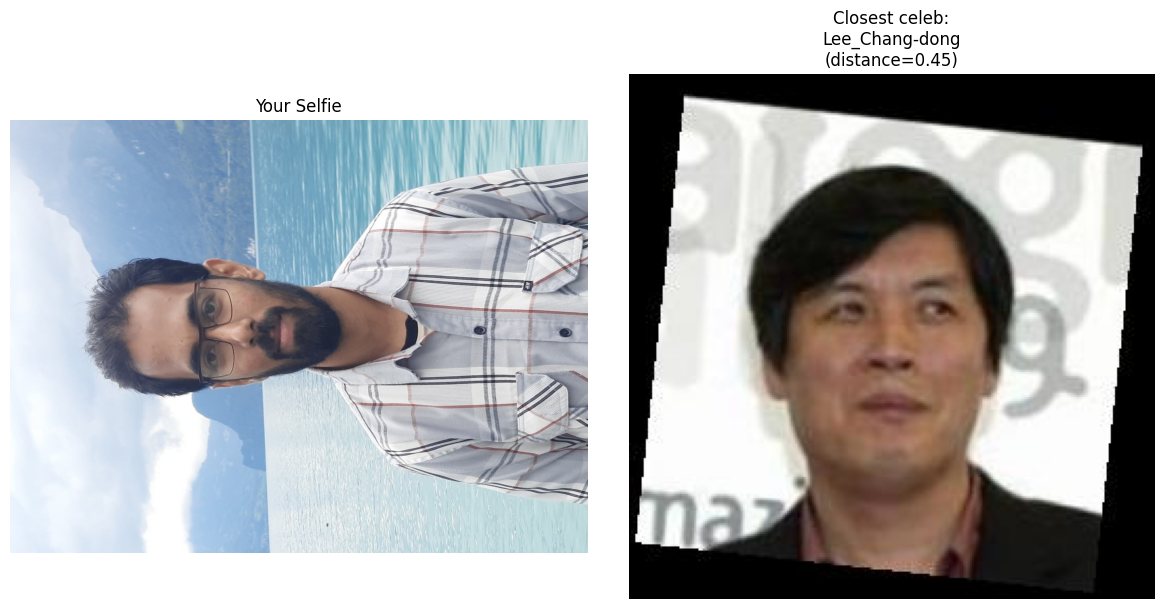

In [66]:
photo_path ="/home/user/javeda1/ahmad_1.jpg"
display_photo_and_closest_celeb(
    photo_path=photo_path,
    model=model,
    transform=test_transform,
    device=device,
    celebrity_refs=celebrity_refs,
    celebrity_imgs=people_dict_train
)